In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import log_loss,auc,classification_report,roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn import tree
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns', None)
%matplotlib inline

In [5]:
import sys
sys.path.append("..")
from ICM_utils import helper, evaluation, metrics
# gbm is obsolete (for now), restructured into utils

## 1. Amelia and MICE imputed dataset using no censoring (full data)
* Amelia takes precedence
* Some pre-processing
* Need to run the model on 
    - missing data dataset 
    - GBM only dataset
    - standardized imputed no preprocessing dataset


# Gower distance example 

In [6]:
X2 = np.array([['Syria', 1200, 0,411114.44,True],
                  ['Ireland', 300, 0, 199393333.22, False],
                  ['United Kingdom', 100, 0, 32323222.121, False]], dtype=object)
               
Y2 = np.array([['United Kingdom', 200, 0, 99923921.47, True]], dtype=object)


D = metrics.gower_distances(X2,Y2)

print(D)

[[0.48183999]
 [0.51816001]
 [0.28612829]]


In [ ]:
# Will work by comparing if an instance of X_train has the same form as something similar to X2. 
# Works with NaN values
# We have to define what X_train and Y_train is
k = 3
model = KNeighborsClassifier(n_neighbors=k,metric=metrics.gower_distances)
model.fit(X_train,Y_train)

In [4]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_Amelia_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')

In [5]:
df_amelia = pd.read_csv(DATA_Amelia_FILE)
df_mice = pd.read_csv(DATA_MICE_FILE)

In [6]:
df_amelia.drop("Unnamed: 0", axis = 1, inplace=True)
df_mice.drop("Unnamed: 0", axis = 1, inplace=True)

In [7]:
df_amelia.head(2)

,Gender,Tumor_type,Tumor_grade,Gene_P53,Gene_Mgmt,Gene_Egfr,Gene_Mdm2,Gene_Cdk4,Gene_P16,Gene_Ihc_Atrx,Gene_Ch10Q,Gene_Ch9P,Tumor_Location,Tumor_Position,Surgery_type,Age_surgery,life_expectancy,IDH,TERT,IDH_TERT,X1p19q_codel,IK
0,M,gliome,3,NC,METHYLE,NORMAL,NORMAL,NORMAL,DELETE,Maintien,PERTE,NON PERTE,A,G,partielle,42,30,mutant,wt,3,0,90.512838
1,M,astrocytome,2,NC,NON METHYLE,NORMAL,NORMAL,NORMAL,NORMAL,extinction,NON PERTE,NON PERTE,N,non précisé,exérèse,28,2069,NC,wt,2,0,90.596534


In [8]:
df_amelia.shape

(2086, 22)

In [9]:
# Check for null values - no need here thanks to Alex and Amelia with its mouse
#for col in df_mice.columns:
 #   print('{0}\n  {1}\n'.format(col,df_mice[col].isnull().value_counts()))
# df_1 = df_small.dropna(axis=0, how='any')    

(array([1.572e+03, 2.490e+02, 1.330e+02, 5.900e+01, 3.500e+01, 1.500e+01,
        1.200e+01, 6.000e+00, 4.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.16890e+03, 2.33680e+03, 3.50470e+03, 4.67260e+03,
        5.84050e+03, 7.00840e+03, 8.17630e+03, 9.34420e+03, 1.05121e+04,
        1.16800e+04]),
 <a list of 10 Patch objects>)

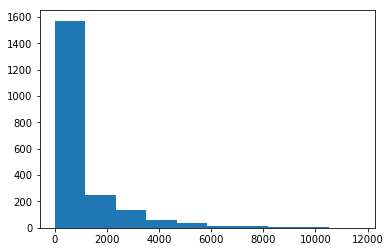

In [10]:
plt.hist(df_amelia.life_expectancy,bins =10)

## Split the predictor into multiple classes
* 3 classes 
* 12 classes
* have an automatic way of splitting the variables

In [11]:
# Try with three classes first
labels = ["6months","1.2year","2years","3years","more"]
cut_points = [200,400,700,1100]
#labels = ["3_months","6_months","9_months","12_months","15_months","18_months","2_years","3_years","4_years","5_years","10_years","10_plus_years"]
#cut_points = [90,180,270,360,450,540,720,1095,1460,1825,3650]

df_amelia.loc[:,"life_expectancy_bin"] = helper.binning(df_amelia.life_expectancy, cut_points, labels)
print(pd.value_counts(df_amelia.life_expectancy_bin, sort=False))

6months    300
1.2year    403
2years     520
3years     312
more       551
Name: life_expectancy_bin, dtype: int64


In [12]:
df_amelia.life_expectancy_bin.values

onths, more, 1.2year, 1.2year, 2years, ..., 6months, 1.2year, 6months, more, 1.2year]
Length: 2086
Categories (5, object): onths < 1.2year < 2years < 3years < more]

Below plot just shows relation between variables and predictor as pairplot (joint distribution)
Should be able to do this for everything
* Observe how for tumor grade 4 the blue part is highly likely - you'll leave less then 1.5 years unfortunately. 
* Looking at life expectancy and age surgery we see no obvious relationship, other than it's slightly to the left, so younger patients should live longer. 
* For IK it's the exact opposite, it seems that patients with IK will survive longer

In [ ]:
g = sns.pairplot(data=df_amelia,hue='life_expectancy_bin',size=3,kind='scatter')

## Display all posibilities  for each dataset 

In [13]:
for column in df_amelia:
    unique_vals = np.unique(df_amelia[column])
    nr_vals = len(unique_vals)
    if nr_vals < 20:
        print('Number of values for attribute {}: {} -- {}'.format(column, nr_vals, unique_vals))
    else:
        print('Number of values for attribute {}: {}'.format(column, nr_vals))

Number of values for attribute Gender: 2 -- ['F' 'M']
Number of values for attribute Tumor_type: 7 -- ['GBM' 'astrocytome' 'astrocytome gémistocytique (=A2)'
 'astrocytome pilocytique' 'gangliogliome' 'gliome' 'oligo']
Number of values for attribute Tumor_grade: 4 -- [1 2 3 4]
Number of values for attribute Gene_P53: 3 -- ['ALTERE' 'NC' 'NORMAL']
Number of values for attribute Gene_Mgmt: 2 -- ['METHYLE' 'NON METHYLE']
Number of values for attribute Gene_Egfr: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Mdm2: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Cdk4: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_P16: 2 -- ['DELETE' 'NORMAL']
Number of values for attribute Gene_Ihc_Atrx: 3 -- ['Extinction diffuse' 'Maintien' 'extinction']
Number of values for attribute Gene_Ch10Q: 2 -- ['NON PERTE' 'PERTE']
Number of values for attribute Gene_Ch9P: 3 -- ['GAIN' 'NON PERTE' 'PERTE']
Number of values for attribute Tumor_Location: 5 -- ['A' 'B' 

Create two encodings for the dataset: 
* Categorical, no order - only used for visualization purposes
* Dummies

Some questions:
* Should we standardize the continuous variables? 
* Label Encoder is used only for visualization purposes, we use One-hot-encoding (dummies) for our analysis

## Label Encoding
Not used at the moment

In [ ]:
le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
df_visualizer = df_amelia.copy(deep=True) 
# Loop over attributes by excluding the continuous oness
for column in df_visualizer.drop(['Age_surgery', 'life_expectancy', 'Tumor_grade','IDH_TERT','IK'], axis=1):  
    le = LabelEncoder().fit(df_visualizer[column]) # Initialise the LabelEncoder and fit
    df_visualizer[column] = le.transform(df_visualizer[column]) # Transform data and save in credit_clean DataFrame
    le_dict[column] = le # Store the LabelEncdoer in dictionary

## One Hot Encoding

In [14]:
df = df_amelia.copy(deep=True)
non_dummy_cols = ['Tumor_grade','IDH_TERT','life_expectancy','life_expectancy_bin','Gender','IK','Age_surgery']
dummy_cols = list(set(df.columns) - set(non_dummy_cols))

df = pd.get_dummies(df,columns=dummy_cols)

df.Gender.replace(to_replace={'M':1, 'F':0},inplace=True)
df.head(2)

,Gender,Tumor_grade,Age_surgery,life_expectancy,IDH_TERT,IK,life_expectancy_bin,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,X1p19q_codel_0,X1p19q_codel_1,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,TERT_mutant,TERT_wt,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,IDH_NC,IDH_mutant,IDH_wt,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction
0,1,3,42,30,3,90.512838,6months,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0
1,1,2,28,2069,2,90.596534,more,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1


In [ ]:
g = sns.pairplot(data=df,vars=['Tumor_grade','IDH_TERT'],hue='life_expectancy_bin',size=3)

## Stage 1: Create training and validation/test (hold-out validation)
* Standardize continuous variables for non-trees methods
* Either fit on train and transform using test only or fit_transform the whole thing (no real test set here) 
* Try with different random seeds to get errors bars

In [15]:
X = df.drop(["life_expectancy","life_expectancy_bin"], axis=1)
Y = df.life_expectancy_bin
#Y = LabelEncoder().fit_transform(df.life_expectancy_bin) 

In [16]:
random_states = [1332, 1, 5 ,8, 100, 78]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=random_states[0])

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train.head(2)

(1564, 54) (522, 54) (1564,) (522,)


,Gender,Tumor_grade,Age_surgery,IDH_TERT,IK,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,X1p19q_codel_0,X1p19q_codel_1,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,TERT_mutant,TERT_wt,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,IDH_NC,IDH_mutant,IDH_wt,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction
172,0,3,90,4,64.175203,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0
1910,0,4,57,4,60.000000,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0


In [ ]:
#continuous_cols = ['Tumor_grade','IDH_TERT','IK','Age_surgery']
#sc = StandardScaler()
#df[continuous_cols] = sc.fit_transform(df[continuous_cols])

## Stage 2: Random Forests and Gradient Boosting Models
### Things to think about 
* Data standardization for the continuous variables - it's not necessary for trees. 
  Why is not necessary, again please? 

* Apply MCA to the categories - not so good according to plots from Alex
* Exploratory data analysis is what's missing here
* AUC seems wrong - double check
* Do Cross Validation with KFold
* Tune learning rate? Tune max_depth? Need some wisdom from somewhere on how to take it to the next step
When we do crossvalidation we'll have a different approach. Perform perhaps MCA
  * Random Forests - done below
  * Wide and Deep NN with Tensorflow - done in a separate notebook
  * K-Means style clustering

In [17]:
X_train.describe(include=[np.number])

,Gender,Tumor_grade,Age_surgery,IDH_TERT,IK,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,X1p19q_codel_0,X1p19q_codel_1,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,TERT_mutant,TERT_wt,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,IDH_NC,IDH_mutant,IDH_wt,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.00000,1564.00000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,0.620844,3.386829,54.038363,3.654092,81.777671,0.023018,0.359974,0.307545,0.309463,0.300512,0.699488,0.126598,0.873402,0.079284,0.920716,0.084399,0.764706,0.150895,0.349744,0.650256,0.054987,0.473785,0.471228,0.902813,0.097187,0.926471,0.014066,0.003836,0.053069,0.002558,0.66688,0.33312,0.434783,0.462916,0.047954,0.003836,0.050512,0.585038,0.085038,0.006394,0.003197,0.008312,0.118286,0.193734,0.214834,0.150895,0.634271,0.492967,0.507033,0.440537,0.559463,0.006394,0.923274,0.070332
std,0.485332,0.810586,15.382637,0.543598,12.287382,0.150008,0.480146,0.461625,0.462420,0.458627,0.458627,0.332629,0.332629,0.270268,0.270268,0.278074,0.424318,0.358061,0.477042,0.477042,0.228028,0.499472,0.499331,0.296307,0.296307,0.261087,0.117803,0.061839,0.224243,0.050524,0.47148,0.47148,0.495887,0.498782,0.213737,0.061839,0.219068,0.492873,0.279028,0.079731,0.056469,0.090820,0.323050,0.395349,0.410838,0.358061,0.481788,0.500110,0.500110,0.496610,0.496610,0.079731,0.266242,0.255788
min,0.000000,1.000000,8.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,43.000000,3.000000,73.828894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,4.000000,55.000000,4.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [18]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

### Baseline Random Forest classifier 

In [19]:
base_rfc = RandomForestClassifier(n_estimators = 500, random_state=1233)
base_rfc.fit(X_train, Y_train)
probas = base_rfc.predict_proba(X_test)
#y_pred_probas = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem --- Score: {1} and Logloss: {2}".format(len(labels), base_rfc.score(X_test,Y_test), error))

For 5 class problem --- Score: 0.4118773946360153 and Logloss: 1.3382778165369436


### Grid Search - with estimators

In [20]:
from sklearn.model_selection import GridSearchCV

In [22]:
# Create a model with 400 estimators for the grid search
rfc = RandomForestClassifier(random_state = 1233)


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10,20,50,100,300,400,500,1000,1500,2000]
}
#"max_features": ['auto','log2']


# Instantiate GRID SEARCH over the space of parameters defined 
# Should we play with CV? 
grid_search = GridSearchCV(estimator = rfc, param_grid=param_grid, 
                           n_jobs = -1, verbose = 2, # Do we need jobs and verbose to change?
                           scoring='neg_log_loss', cv = 3, return_train_score=True)

# Fit the model - should not show processing 
grid_search.fit(X_train, Y_train);

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV]  bootstrap=True, criterio

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_fea

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s


[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000, total=   9.3s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=80, 

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.5s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   7.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000, total=   7.3s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_feature

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   9.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, m

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   7.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_feature

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.6min


[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.7s
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   8.0s
[CV] bootstrap=True, criterion=gini, max_depth=80

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   7.9s
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=80, max

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   7.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=8

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   7.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_featu

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=   2.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, 

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_feat

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.3s
[CV] bootstrap=True, criterion=gini, max_dept

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  3.7min


[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   7.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_f

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   7.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=2000, total=   7.2s
[CV] bootstrap=True, criterion=gini, max_depth=80, 

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=2000, total=   7.8s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=2000, total=   7.4s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min

[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=2000, total=   8.7s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.5s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000, total=   8.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.6s
[CV] bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=80,

[CV]  bootstrap=True, criterion=gini, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000, total=   8.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_f

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.9s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=90, 

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.6s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, total=   2.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400, total=   1.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, total=   2.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000, total=   9.8s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, m

[Parallel(n_jobs=-1)]: Done 651 tasks      | elapsed:  6.6min


[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   3.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   3.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   3.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1500, total=   5.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, 

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   5.8s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=  13.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_fea

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   9.8s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1500 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=  10.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1500, total=  15.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1500, total=  14.8s
[CV] bootstrap=True, criterion=gini, max_dep

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=  10.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=  16.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=  17.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=  17.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, 

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500, total=  32.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500, total=  25.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500, total=  25.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_featu

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500, total=  23.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500, total=  20.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1500, total=  19.8s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90,

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500, total=  24.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1500, total=  24.7s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=  16.9s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, m

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1500, total=  18.9s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_feature

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_fea

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_s

[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3

[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed: 19.0min


[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=  13.0s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_fe

[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=90, max_features=3, min_s

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_fe

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100,

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100,

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=

[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_fe

[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   1.3s
[CV] bootstrap=True, criterion=gini, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=100, max_features=

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels) - what is this one? what are the test_features? 
best_grid

In [ ]:
# Compare to previous approach - I don't think this one is better (Fix helper)
#df = pd.DataFrame.from_dict(grid_search.cv_results_) 
#helper.write_to_pickle(df,"RandomForest_CV_400estimators")

### Final Model 
* 1 - If CV contains estimators, code rungs a long time, use saved gridCV.
* 2 - If CV doesn't contain estimators 

In [ ]:
#Do not run this one 
# Random forests with the right number of estimators based on validation set
l = np.array(labels)
# rfc = best result from above
rfc=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)
    
rfc.fit(X_train, Y_train)
    
score = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
    
# Confusion matrix      
cfm = confusion_matrix(Y_test, l[y_pred])
    
# ROC-AUC needs fixing.  
Y_test_binary = label_binarize(Y_test, classes=labels)
y_pred_binary = label_binarize(l[y_pred],classes =labels)
auc_curve = evaluation.multi_class_auc(len(l),Y_test_binary,y_pred_binary)

### Merge training and validation and run the same model - maybe not
 * Pick n_estimators = 100 to maximize accuracy

In [ ]:
#X_tr_merge = pd.concat((X_train,X_test)).as_matrix()
#Y_tr_merge = pd.concat((Y_train,Y_test)).as_matrix()

In [ ]:
rfc_merge=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                max_depth=80, max_features=3, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=3, min_samples_split=8,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=1233, verbose=0,
                warm_start=False)

rfc_merge.fit(X_train, Y_train)



# Accuracy on test
accuracy = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc_merge.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

# Confusion matrix      
cfm = confusion_matrix(Y_test, l[y_pred])

## Stage 3: EVALUATION: Confusion Matrix, ROC-AUC

In [ ]:
print("For {0} class problem --- Score: {1} and Logloss: {2}".format(len(labels), accuracy, error))

In [ ]:
plt.figure()
evaluation.plot_confusion_matrix(cfm, norm=True, classes=labels)
plt.xlabel('Interpreted cluster label')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))

ax[0].scatter(estimators_range, errors)
ax[0].set_ylabel('Log-loss error on validation set')
ax[0].set_xlabel('Number of estimators for Random Forest Classifier');

ax[1].scatter(estimators_range, accuracies)
ax[1].set_ylabel('Accuracies on validation set')
ax[1].set_xlabel('Number of estimators for Random Forest Classifier');

ax[2].scatter(estimators_range, roc_auc)
ax[2].set_ylabel('AUC on validation set')
ax[2].set_xlabel('Number of estimators for Random Forest Classifier');

## Stage 4: Miscellaneous
 * Grid Search done 
 * Decide on each hyperparameter what its value should be then mix the val and train together to do the prediction

In [ ]:
# Random forests n_estimators based on validation set
estimators_range = [100, 200, 300, 400, 500, 1000, 2000]
accuracies = []
errors = []
roc_auc = []
cm = []
l = np.array(labels)
i=0
for n_estimators in estimators_range:
    rfc=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)
    
    rfc.fit(X_train, Y_train)
    
    # Accuracy
    accuracies.append(rfc.score(X_test,Y_test)) 
    
    # XEntropy Error
    probas = rfc.predict_proba(X_test)
    y_pred = np.argmax(probas, axis=1)
    error = log_loss(Y_test,probas)
    errors.append(error)
    
    # Confusion matrix      
    cfm = confusion_matrix(Y_test, l[y_pred])
    cm.append(cfm)
    
    # ROC-AUC - needs fixing for multi class AUC. But fixing ASAP 
    Y_test_binary = label_binarize(Y_test, classes=labels)
    y_pred_binary = label_binarize(l[y_pred],classes =labels)
    auc_curve = evaluation.multi_class_auc(len(l),Y_test_binary,y_pred_binary)
    roc_auc.append(auc_curve)
    i+=1
    print("Logloss {} -- Random Forest Classifier with features = {}, max_depth = {}, estimators = {} -- {}/{}".format(error,rfc.max_features,rfc.max_depth,n_estimators,i,len(estimators_range)))

optimal_acc_index = np.argmax(accuracies)
optimal_err_index = np.argmin(errors)
n_estimators_optimal_accuracy = estimators_range[optimal_acc_index]
n_estimators_optimal_error = estimators_range[optimal_err_index]
optimal_acc = accuracies[optimal_acc_index]
optimal_err = errors[optimal_err_index]

print("Optimal Random Forest Classifier for {0} class problem has Score: {1} and Logloss {2}".format(len(labels),optimal_acc,optimal_err))

# Pick one of them for the final merged training - You can see 100 is pretty good even though you ran CV on 400.
# Should re-run CV with 100. 
print('Optimal number of estimators based on validation set: {}\n Accuracy on validation set: {:.3f}'.
    format(n_estimators_optimal_accuracy, optimal_acc))
      
print('Optimal number of estimators based on validation set: {}\n Log-Loss on validation set: {:.3f}'.
    format(n_estimators_optimal_error, optimal_err))

### Gradient Boosting similar to Random forests

In [ ]:
# Gradient Boosting classifiers based on validation/test
estimators_range = [100, 200, 300, 400, 500, 1000, 2000]
accuracies = []
errors = []
roc_auc = []
cm = []
l = np.array(labels)

for n_estimators in estimators_range:
    gbc = GradientBoostingClassifier(learning_rate= 0.03, 
                                     n_estimators=n_estimators,
                                     max_depth =30,                          
                                     random_state = 1123)
    gbc.fit(X_train, Y_train)
    
    # Accuracy
    accuracies.append(gbc.score(X_test,Y_test)) 
    
    # XEntropy Error
    probas = gbc.predict_proba(X_test)
    y_pred = np.argmax(probas, axis=1)
    errors.append(log_loss(Y_test,probas))
    
    # ROC-AUC or Confusion matrix      
    cfm = confusion_matrix(Y_test, l[y_pred])
    cm.append(cfm)

#n_estimators_optimal_accuracies = estimators_range[np.argmax(accuracies)]
#n_estimators_optimal_errors = estimators_range[np.argmin(errors)]

In [ ]:
# Feature importance in descending order
feat_order_ind = np.argsort(rf_ind.feature_importances_)[::-1] # In descending order
print('50 most important features in order of decreasing importance: \n{}'.
      format(train_A.drop(["imgId", "is_person"], axis=1).columns[feat_order_ind[0:50]]))

title = 'Learning Curves (NN with tuned hyperparameters)'    
estimator = nn01_opt # regressor with tuned hyperparameters 
plot_learning_curve(estimator, title, sine_X_train, sine_y_train, 
                    ylim=(-10., 0.), cv=5, n_jobs=-1, scoring='mean_squared_error')
plt.grid(True)
plt.show()

## Exporting data to a tree style graph for interpretation

In [ ]:
dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names= df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
    class_names = labels,  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph
#To create a file do this:
#To create a file do this:
with open("tree.dot", 'w') as f:
     f = export_graphviz(dt, out_file=f,
                         feature_names = df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
                         class_names = labels,   
                         filled=True, rounded=True,  
                         special_characters=True)